# APM Project - Object Detection using Google AI Open Images

In [1]:
# Sequential is the simplest type of Keras Model
from keras.models import Sequential
# Importing some of the metrics from Keras 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

### Reading the image ids to explore the data

In [2]:
images_bb_box = pd.read_csv('./Data/train-annotations-bbox.csv')

### Columns in the image_bb_box file

In [6]:
images_bb_box.columns.values

array(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax',
       'YMin', 'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf',
       'IsDepiction', 'IsInside'], dtype=object)

#### Exploring the data set

In [8]:
images_bb_box.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [53]:
# Get the list of all the images which are present in the subset of train data (200K images)

import os
train_image_ids = os.listdir('./Data/train_00/train_00')

In [54]:
print ('The total number of images we will use to subset the training data is', len (train_image_ids))

The total number of images we will use to subset the training data is 200000


In [55]:
# Replacing '.jpg' from image_ids
subset_imageids = []
for image_id in train_image_ids:
    image_id = image_id.replace('.jpg','')
    subset_imageids.append(image_id)

In [56]:
# Creating the subset of the image data with bounding boxes and class labels
subset_data = images_bb_box[images_bb_box['ImageID'].isin(subset_imageids)]

In [57]:
# Importing class label to definition mapping
class_labels = pd.read_csv('./Data/class-descriptions-boxable.csv',header=None)
class_labels.columns = ['class_label','class_name']

In [58]:
# Map class labels to class name in the subset data

subset_data_merged = subset_data.merge(class_labels,\
                 left_on = 'LabelName',\
                 right_on = 'class_label')

In [59]:
# Checking if there are any missing values for Class labels
subset_data_merged['class_name'].isna().sum()

0

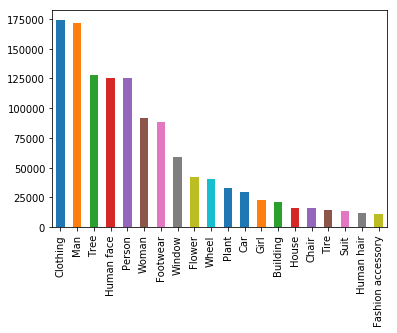

In [60]:
# Getting the top 20 objects in our data
subset_data_merged['class_name'].value_counts()[:20].plot(kind='bar')

In [62]:
# Exporting the subset data to csv
#subset_data_merged.to_csv('./Data/Subset_images_data.csv')

## Loading subset data

In [2]:
subset_data_merged = pd.read_csv('./Data/Subset_images_data.csv')

In [3]:
# Get the list of all the images which are present in the subset of train data (200K images)
import os
train_image_ids = os.listdir('./Data/train_00/train_00')

## Getting the dimensions of every image

In [31]:
new_dict = {}
%pylab inline
from PIL import Image
for i in train_image_ids:
    im = Image.open("./Data/train_00/train_00/"+ i)
    width, height = im.size
    image = i.replace('.jpg','')
    new_dict[image]= (width,height) 

Populating the interactive namespace from numpy and matplotlib


In [41]:
# Creating data frame from dictionary
new_df = pd.DataFrame.from_dict(new_dict, orient='index')
new_df.reset_index(inplace = True)
new_df.columns = ['ImageID','width','height']

## Merging image size to the subset data set

In [57]:
merged_df = subset_data_merged.merge(new_df,left_on = 'ImageID',\
                         right_on = 'ImageID',\
                         how = 'left')
merged_df = merged_df.drop('Unnamed: 0',axis=1)

In [59]:
# Exporting the merged data frame to csv
#merged_df.to_csv('./Data/subset_data_with_imagesize.csv',index = False)

## Create a dictionary of image size and bounding box dimensions for the input into YOLO

In [61]:
open_image_data = pd.read_csv('./Data/subset_data_with_imagesize.csv')

In [ ]:
yolo_input_format =[]
for file_name in train_image_ids:
    train_image_dict = {}
    image_id = file_name.replace('.jpg','')
    width = open_image_data[open_image_data['ImageID'] == image_id]['width'].iloc[0]
    height = open_image_data[open_image_data['ImageID'] == image_id]['height'].iloc[0]
    train_image_dict['filename'] = './Data/train_00/train_00/' + file_name
    train_image_dict['width'] = width
    train_image_dict['height'] = height
    all_objects_df = open_image_data[open_image_data['ImageID'] == image_id]
    object_list = []
    for i in range(len(all_objects_df)):
        bbox = {}
        bbox['name'] = all_objects_df['class_name'].iloc[i]
        bbox['xmin'] = all_objects_df['XMin'].iloc[i]*width
        bbox['ymin'] = all_objects_df['YMin'].iloc[i]*height
        bbox['xmax'] = all_objects_df['XMax'].iloc[i]*width
        bbox['ymax'] = all_objects_df['YMax'].iloc[i]*height
        object_list.append(bbox)
    train_image_dict['object'] = object_list
    yolo_input_format.append(train_image_dict)    

### Plotting a bounding box on an image

In [258]:
# Getting the image in python notebook
%pylab inline
from PIL import Image
im = Image.open("./Data/train_00/train_00/"+ train_image_ids[0])
print(im.size)
image = train_image_ids[0].replace('.jpg','')
image_data_bbox = subset_data_merged [subset_data_merged ['ImageID'] == image]

Populating the interactive namespace from numpy and matplotlib
(1024, 768)


C:\Users\bandi\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [259]:
image_data_bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,class_label,class_name
0,dec2aafe511bcd90,activemil,/m/07j7r,1,0.016250,0.346875,0.060833,0.532500,1,1,0,0,0,/m/07j7r,Tree
1,dec2aafe511bcd90,xclick,/m/07j7r,1,0.170000,0.246250,0.003333,0.165000,1,1,0,0,0,/m/07j7r,Tree
2,dec2aafe511bcd90,xclick,/m/07j7r,1,0.530625,0.808125,0.000000,0.430833,1,1,0,0,0,/m/07j7r,Tree
3,dec2aafe511bcd90,xclick,/m/07j7r,1,0.564375,0.728125,0.163333,0.505833,1,0,0,0,0,/m/07j7r,Tree
4,dec2aafe511bcd90,xclick,/m/07j7r,1,0.750000,0.999375,0.000000,0.201667,1,1,0,0,0,/m/07j7r,Tree


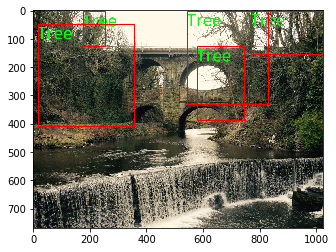

In [260]:
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import numpy as np

#image_plot = np.array(Image.open(("./Data/train_00/train_00/"+ train_image_ids[0])), dtype=np.uint8)

image_plot = Image.open("./Data/train_00/train_00/"+ train_image_ids[0])

# Create figure and axes
fig, ax = plt.subplots(1)



for i in range(len (image_data_bbox)):
    
    xmin = image_data_bbox['XMin'].iloc[i]
    xmax = image_data_bbox['XMax'].iloc[i]
    ymin = image_data_bbox['YMin'].iloc[i]
    ymax = image_data_bbox['YMax'].iloc[i]

    width = xmax - xmin
    height = ymax - ymin
    
    # Scaling coordinates of bounding box to match the image size
    scaled_width = width*im.size[0]
    scaled_height = height*im.size[1]
    xmin_scaled = xmin*im.size[0]
    ymin_scaled = ymin*im.size[1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin_scaled,ymin_scaled),scaled_width,scaled_height,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    object_name = image_data_bbox['class_name'].iloc[i]
    
    draw = ImageDraw.Draw(image_plot)
    font = ImageFont.truetype("ABeeZee-Regular.otf", 60)
    draw.text((xmin_scaled, ymin_scaled),object_name,(0,255,0),font=font)
    
# Display the image
ax.imshow(image_plot)


    
plt.show()

In [2]:
import numpy as  np

In [12]:
np.random.randn(19*19, 5, 1) * np.random.randn(19*19, 5, 80)

array([[[-3.48391360e-01, -3.80391569e-02, -1.52611707e+00, ...,
          9.97442894e-01,  3.58430862e-01, -7.43764326e-02],
        [-1.37950084e-02, -2.77933546e-02,  4.38466122e-01, ...,
          7.90624227e-02, -3.86899894e-02,  2.02068552e-01],
        [ 2.82597152e-01, -6.95001359e-01,  2.58626667e-01, ...,
         -7.61220554e-01,  5.82048513e-01,  6.73812656e-02],
        [ 1.34331850e-01,  2.57560116e-01, -2.22511115e-01, ...,
          7.65542189e-02,  4.30401632e-01, -1.56458546e-02],
        [ 1.52821204e-03, -8.18529759e-01,  2.49916840e-01, ...,
         -2.19323544e-01,  1.21041569e+00,  1.29029767e+00]],

       [[ 7.45590475e-01,  8.91285980e-02,  3.53143328e-01, ...,
          1.10339351e-01, -6.36676596e-01, -2.01874152e-01],
        [-4.81263840e-02,  1.78886403e-02, -4.74078269e-02, ...,
         -3.08572858e-02,  4.32631866e-03,  2.59874926e-02],
        [-2.10302165e-02, -6.25204845e-02, -2.97292417e-01, ...,
         -3.11144694e-02, -1.23375828e-01,  2.08765

In [27]:
box_scores = np.random.randn(5, 2,1) * np.random.randn(5, 2,20)

In [28]:
from keras import backend as K

In [32]:
box_classes = K.argmax(box_scores, axis=-1)
box_class_scores = K.max(box_scores, axis=None, keepdims=False)

In [34]:
box_class_scores

<tf.Tensor 'Max:0' shape=() dtype=float64>

# Let's Try If The Code Below Works

# We should keep the above part clean

# We will train the last layer of Yolo on our own

In [102]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2

# The below 2 imports are done from preprocessing.py and utils.py in the utils folder of Anaconda (C:\Users\bandi\Anaconda3\Lib\site-packages\utils)
# These files were manually added so that these functions could be imported.

from utils.preprocessing import parse_annotation, BatchGenerator
from utils.utils import WeightReader, decode_netout, draw_boxes

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\bandi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [131]:
LABELS = ['Clothing', 'Man', 'Tree', 'Human face', 'Person', 'Woman', 'Footwear', 'Window', 'Flower', 'Wheel',\
          'Plant', 'Car', 'Girl', 'Building', 'House', 'Chair', 'Tire', 'Suit', 'Human hair', 'Fashion accessory']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
# Getting the total number of classes/labels we wil be predicting.
CLASS            = len(LABELS)
# Assigning 1's to all class labels
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

# Pr (object in class) * Pr (class of the object) < Obj_threshold, then it disregards this anchor box
OBJ_THRESHOLD    = 0.3#0.5

# If there are many overlapping boxes and IOU is > NMS_thereshold, then we will drop the one with a lower probability. 
NMS_THRESHOLD    = 0.3#0.45

ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [132]:
wt_path = 'Weights/yolo.weights'                      
#train_image_folder = 'coco/train2014/'
#train_annot_folder = '/home/andy/data/coco/train2014ann/'
#valid_image_folder = '/home/andy/data/coco/val2014/'
#valid_annot_folder = '/home/andy/data/coco/val2014ann/'

# Construct the network

In [133]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
#Here x is the input. This function basically converts height and widths to depths.
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [134]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

# Architecture of YOLO Model

In [107]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 26, 26, 256)  0           norm_12[0][0]                    
__________________________________________________________________________________________________
conv_13 (Conv2D)                (None, 26, 26, 512)  1179648     leaky_re_lu_12[0][0]             
__________________________________________________________________________________________________
norm_13 (BatchNormalization)    (None, 26, 26, 512)  2048        conv_13[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 26, 26, 512)  0           norm_13[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 13, 13, 512)  0           leaky_re_lu_13[0][0]             
__________

# Load Pre trained weights 

In [135]:
from utils.utils import WeightReader
weight_reader = WeightReader(wt_path)

In [136]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

# Randomize weights of last layer

In [137]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# Perform trainig to re-train last layer on our specific data set

In [138]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

# Pass the annotations to construct train generator and validation generator

In [139]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

# Normalize image size

In [113]:
def normalize(image):
    return image / 255.

In [114]:
train_imgs = yolo_input_format

In [126]:
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

In [120]:
# For now, lets make validation image as train images
valid_imgs = yolo_input_format
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

# Setup a few callbacks and start the training

In [141]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [142]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'google_open_images_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'google_open_images_' + '_' + str(tb_counter), 
                           histogram_freq=0, 
                           write_graph=True, 
                           write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = 20, 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = 20,
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/100
20/20 [==============================] - ETA: 16:51 - loss: 0.12 - ETA: 14:56 - loss: 0.12 - ETA: 13:43 - loss: 0.12 - ETA: 12:41 - loss: 0.11 - ETA: 11:55 - loss: 0.11 - ETA: 11:04 - loss: 0.11 - ETA: 10:09 - loss: 0.11 - ETA: 9:17 - loss: 0.1130 - ETA: 8:27 - loss: 0.111 - ETA: 7:39 - loss: 0.110 - ETA: 6:51 - loss: 0.108 - ETA: 6:04 - loss: 0.107 - ETA: 5:17 - loss: 0.106 - ETA: 4:31 - loss: 0.104 - ETA: 3:45 - loss: 0.103 - ETA: 2:59 - loss: 0.102 - ETA: 2:14 - loss: 0.100 - ETA: 1:29 - loss: 0.099 - ETA: 44s - loss: 0.098 - 1097s 55s/step - loss: 0.0970 - val_loss: 0.0913

Epoch 00001: val_loss improved from inf to 0.09134, saving model to weights_coco.h5
Epoch 2/100
20/20 [==============================] - ETA: 14:09 - loss: 0.07 - ETA: 13:17 - loss: 0.07 - ETA: 12:29 - loss: 0.07 - ETA: 11:41 - loss: 0.06 - ETA: 10:52 - loss: 0.06 - ETA: 10:07 - loss: 0.06 - ETA: 9:22 - loss: 0.0676 - ETA: 8:38 - loss: 0.067 - ETA: 7:55 - loss: 0.066 - ETA: 7:12 - loss: 0.065 - ETA: 

KeyboardInterrupt: 